In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 14.2 MB/s 
     |████████████████████████████████| 120 kB 72.2 MB/s 
     |████████████████████████████████| 6.6 MB 59.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 14.1 MB/s 
     |████████████████████████████████| 115 kB 72.6 MB/s 
     |████████████████████████████████| 212 kB 72.8 MB/s 
     |████████████████████████████████| 127 kB 73.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 15.4 MB/s 


In [3]:
!nvidia-smi

Sun Sep 18 09:30:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
import gc
import math
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm
import re
import html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam, SGD, AdamW, RAdam
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold,GroupKFold
from sklearn.metrics import log_loss,f1_score

from transformers import AutoModel, AutoConfig, AutoTokenizer, AdamW, DataCollatorWithPadding
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [5]:
DIR = '/content/drive/MyDrive/Competitions/Signate/MUFJ'
INPUT_DIR = os.path.join(DIR,'input')
OUTPUT_DIR = os.path.join(DIR,'output')
OUTPUT_SUB_DIR = os.path.join(OUTPUT_DIR,'submission')
#OUTPUT_MODEL_DIR = os.path.join(OUTPUT_DIR,'model')
OUTPUT_MODEL_DIR = DIR + '/output/model/EXP21/'
if not os.path.exists(OUTPUT_MODEL_DIR):
    os.makedirs(OUTPUT_MODEL_DIR)

In [6]:
class CFG:
    num_workers=4
    path=OUTPUT_MODEL_DIR
    config_path=path+'config.pth'
    model="microsoft/deberta-v3-base"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True

In [7]:
def get_score(labels, outputs):
    thresh = 0.5
    y_pred = outputs
    y_true = labels
    return f1_score(y_true, (y_pred>thresh).astype(int))


def get_logger(filename=OUTPUT_MODEL_DIR+'train'):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=CFG.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=CFG.seed)

In [8]:
def freeze(module):
    """
    Freezes module's parameters.
    """
    
    for parameter in module.parameters():
        parameter.requires_grad = False
        
def get_freezed_parameters(module):
    """
    Returns names of freezed parameters of the given module.
    """
    
    freezed_parameters = []
    for name, parameter in module.named_parameters():
        if not parameter.requires_grad:
            freezed_parameters.append(name)
            
    return freezed_parameters

def set_embedding_parameters_bits(embeddings_path, optim_bits=32):
    """
    https://github.com/huggingface/transformers/issues/14819#issuecomment-1003427930
    """
    
    embedding_types = ("word", "position", "token_type")
    for embedding_type in embedding_types:
        attr_name = f"{embedding_type}_embeddings"
        
        if hasattr(embeddings_path, attr_name): 
            bnb.optim.GlobalOptimManager.get_instance().register_module_override(
                getattr(embeddings_path, attr_name), 'weight', {'optim_bits': optim_bits}
            )

In [10]:
oof_df = pd.read_pickle(CFG.path+'oof_df.pkl')
#English_Country = ['US','CA','GB','AU','NZ']
#oof_df = oof_df.loc[~oof_df['country'].isin(English_Country)]
#oof_df = oof_df.reset_index(drop=True)
labels = oof_df['state'].values
preds = oof_df['pred'].values
score = get_score(labels, preds)
LOGGER.info(f'CV Score: {score:<.4f}')

CV Score: 0.8079
INFO:__main__:CV Score: 0.8079


In [ ]:
test = pd.read_csv(os.path.join(INPUT_DIR,'test.csv'))
sub = pd.read_csv(os.path.join(INPUT_DIR,'sample_submit.csv'),header=None)
sub.columns = ['id','state']

In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub('',text)

def remove_html(text):
    html=re.compile(r"<[^>]*?>")
    return html.sub('',text)

def cleaning(texts):
    clean_texts = []
    for text in texts:
        # htmlタグを削除
        text = remove_URL(text)
        text = remove_html(text)
        #アルファベット以外をスペースに置き換え
        #clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        #改行削除
        #text = text.replace("\n","")
        clean_texts.append(text)
    return clean_texts

def get_goal_values(df):
  df["goal"].replace("100000+","100000-100000",inplace=True)
  _df = df["goal"].str.split('-').apply(pd.Series).astype(float)
  _df.columns = ["goal_max","goal_min"]
  df["goal_max"] = _df["goal_max"].astype(str)
  df["goal_min"] = _df["goal_min"].astype(str)
  df["goal_median"] = _df[["goal_max","goal_min"]].median(axis=1)
  df["goal_median"] = df["goal_median"].astype(int)
  return df

if CFG.clean_content==True:
    test['html_content'] = test['html_content'].map(lambda x: str(x))
    test['html_content'] = test['html_content'].apply(html.unescape)
    p = re.compile(r"<[^>]*?>|&amp;|[/'’\"”]")
    test['html_content'] = test['html_content'].map(lambda x: p.sub("", x))
    test['html_content'] = test['html_content'].map(lambda x: x.lstrip())
    test['html_content'] = test['html_content'].fillna('missing')

test = get_goal_values(test)
test['inputs'] = test.goal_median.astype(str) + ' [SEP] ' + test.duration.astype(str) + ' [SEP] ' + test.country + ' [SEP] ' + test.category1 + ' [SEP] ' + test.category2 + ' [SEP] ' + test.html_content

In [ ]:
# ====================================================
# tokenizer
# ====================================================
CFG.tokenizer = AutoTokenizer.from_pretrained(CFG.path+'tokenizer/')

In [ ]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False,
                           truncation=True)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TestDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.inputs = df['inputs'].values

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.inputs[item])
        return inputs

In [ ]:
# ====================================================
# Model
# ====================================================
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class MaxPooling(nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim=1)
        return max_embeddings
    

class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()

        # Freezing
        if cfg.freezing:
            # freezing embeddings and first 2 layers of encoder
            freeze((self.model).embeddings)
            freeze((self.model).encoder.layer[:2])
            cfg.after_freezed_parameters = filter(lambda parameter: parameter.requires_grad, (self.model).parameters())

        #self.pool = MeanPooling()
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

In [ ]:
# ====================================================
# inference
# ====================================================
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
test_dataset = TestDataset(CFG, test)
test_loader = DataLoader(test_dataset,
                         batch_size=CFG.batch_size,
                         shuffle=False,
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
predictions = []
for fold in CFG.trn_fold:
    model = CustomModel(CFG, config_path=CFG.config_path, pretrained=False)
    state = torch.load(CFG.path+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader, model, device)
    predictions.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions = np.mean(predictions, axis=0)

100%|██████████| 307/307 [01:43<00:00,  2.97it/s]


In [ ]:
submit = sub.copy()
#submit.columns = ["id","label"]


submit['label'] = predictions
submit['state'] = (predictions>0.5).astype(int)

submit[["id","state"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"exp021_submission8079.csv"),index=False,header=False)
display(submit)

,id,state,label
0,test_00000,1,0.634162
1,test_00001,1,0.982648
2,test_00002,1,0.971256
3,test_00003,0,0.195137
4,test_00004,0,0.083797
...,...,...,...
9795,test_09795,1,0.831427
9796,test_09796,1,0.982729
9797,test_09797,0,0.142921
9798,test_09798,1,0.856076


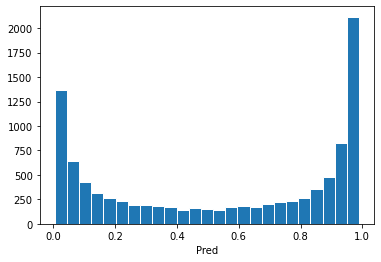

In [ ]:
plt.hist(submit.label,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

In [ ]:
#train,testでダブっているデータを参照
dup_test_ids = ['test_01704','test_03707','test_04353','test_04453','test_04645','test_06909','test_08232']
sub_dup= submit[submit["id"].isin(dup_test_ids)]  

In [ ]:
T = pd.DataFrame([['train_00365','train_01463','train_02156','train_04506','train_06891','train_08302','train_09470'],
                [0,1,1,1,1,1,0],
                ['test_08232','test_01704','test_06909','test_04453','test_03707','test_04353','test_04645']]).T
T.columns =["train id","true label","id"]
T = T.sort_values(by="id")
T = T.merge(sub_dup,how='left',on='id')
T

,train id,true label,id,state,label
0,train_01463,1,test_01704,1,0.972464
1,train_06891,1,test_03707,1,0.963867
2,train_08302,1,test_04353,1,0.875301
3,train_04506,1,test_04453,1,0.987193
4,train_09470,0,test_04645,1,0.617507
5,train_02156,1,test_06909,1,0.739733
6,train_00365,0,test_08232,1,0.504828
